# Train cell typing model with Immunocto

ImmunOcto paper: [https://arxiv.org/abs/2406.02618](https://arxiv.org/abs/2406.02618)

## 1. Download Immunocto dataset

Dataset on Zenodo: [https://zenodo.org/records/11073373](https://zenodo.org/records/11073373)

## 2. Unzip the image folders

In [ ]:
%%sh
DATA_DIR="/Users/amc/Downloads/Immunocto"
for file in "${DATA_DIR}"/*.gz; do
  echo "$file"
  tar -xzf "$file" -C "$DATA_DIR"
done

## 3. Explore metadata

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "/Users/amc/Downloads/Immunocto"

In [2]:
metadata_file = os.path.join(DATA_DIR, "curated_ImmunoctoV1_refinement2.csv")
meta_df = pd.read_csv(metadata_file)
meta_df

,patient,class,cx,cy,mask
0,CRC01,cd4,45678,72401,cd4_45678_72401.png
1,CRC01,cd4,49689,51172,cd4_49689_51172.png
2,CRC01,cd4,36430,64060,cd4_36430_64060.png
3,CRC01,cd4,16642,21727,cd4_16642_21727.png
4,CRC01,cd4,39649,56515,cd4_39649_56515.png
...,...,...,...,...,...
6848449,CRC40,other,29894,54094,other_29894_54094.png
6848450,CRC40,other,26630,56800,other_26630_56800.png
6848451,CRC40,other,10245,51446,other_10245_51446.png
6848452,CRC40,other,32019,5435,other_32019_5435.png


In [3]:
print(f"cell type classes: \n\t{meta_df['class'].unique()}\n")
print(f"patients: \n\t{meta_df['patient'].unique()}")

cell type classes: 
	['cd4' 'cd8' 'macrophage' 'bcell' 'other']

patients: 
	['CRC01' 'CRC02' 'CRC03' 'CRC04' 'CRC05' 'CRC06' 'CRC07' 'CRC08' 'CRC09'
 'CRC10' 'CRC11' 'CRC12' 'CRC13' 'CRC14' 'CRC15' 'CRC16' 'CRC17' 'CRC18'
 'CRC19' 'CRC20' 'CRC21' 'CRC22' 'CRC23' 'CRC24' 'CRC25' 'CRC26' 'CRC27'
 'CRC28' 'CRC29' 'CRC30' 'CRC31' 'CRC32' 'CRC33' 'CRC34' 'CRC35' 'CRC36'
 'CRC37' 'CRC38' 'CRC39' 'CRC40']


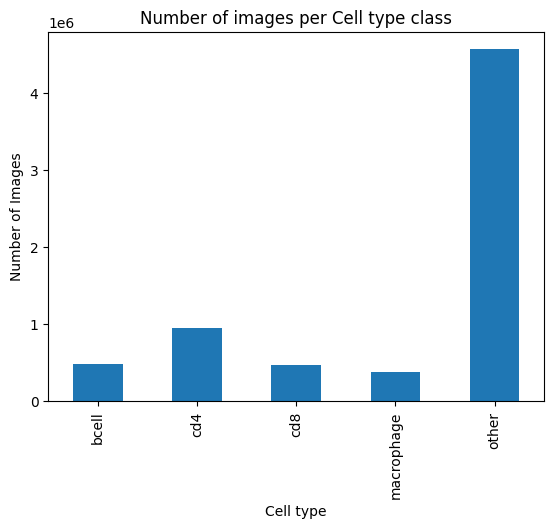

In [4]:
# Calculate value counts
value_counts = meta_df['class'].value_counts().sort_index()

# Create bar plot
value_counts.plot.bar(title='Number of images per Cell type class')
plt.xlabel('Cell type')
plt.ylabel('Number of Images')
plt.show()

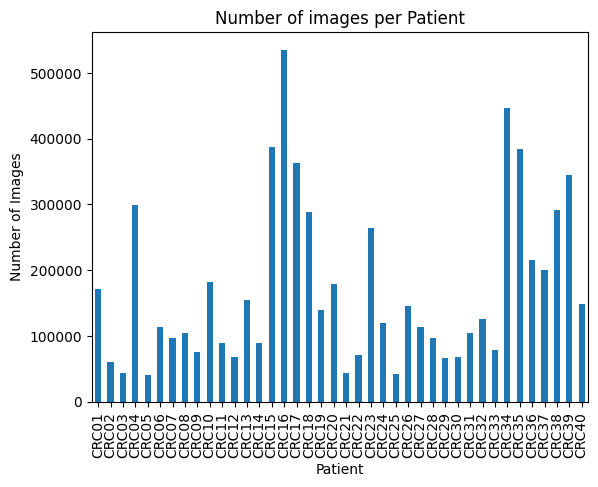

In [5]:
# Calculate value counts
value_counts = meta_df['patient'].value_counts().sort_index()

# Create bar plot
value_counts.plot.bar(title='Number of images per Patient')
plt.xlabel('Patient')
plt.ylabel('Number of Images')
plt.show()

## 4. Define a custom PyTorch Dataset class

In [6]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [7]:
# Create label mapping
unique_classes = meta_df['class'].unique()
label_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
print(label_to_index)

{'cd4': 0, 'cd8': 1, 'macrophage': 2, 'bcell': 3, 'other': 4}


In [8]:
dataset_code = """import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

class ImmunOctoDataset(Dataset):
    def __init__(self, root_dir: str, csv_file: str, label_mapping: dict, transform: transforms=None):
        \"\"\"
        Args:
            root_dir (string): Directory with all the patient subdirectories.
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied to images.
        \"\"\"
        self.root_dir = root_dir
        self.data = pd.read_csv(os.path.join(root_dir, csv_file))
        self.transform = transform
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        patient = row["patient"]
        mask_filename = row["mask"]
        
        he_path = os.path.join(self.root_dir, patient, "HE", mask_filename)
        
        # Load image
        he_image = Image.open(he_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            he_image = self.transform(he_image)

        # Load label as tensor
        class_label = self.label_mapping[row["class"]]
        class_label = torch.tensor(class_label, dtype=torch.long)
        return he_image, class_label
"""

# Write class to file for worker processes, needed for DataLoader's num_workers argument if set >0
with open("dataset.py", "w") as f:
    f.write(dataset_code)

In [9]:
from dataset import ImmunOctoDataset

In [10]:
# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # needed for ResNet50 pretrained
])

dataset = ImmunOctoDataset(root_dir=DATA_DIR, csv_file="curated_ImmunoctoV1_refinement2.csv", 
                           transform=transform, label_mapping=label_to_index)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

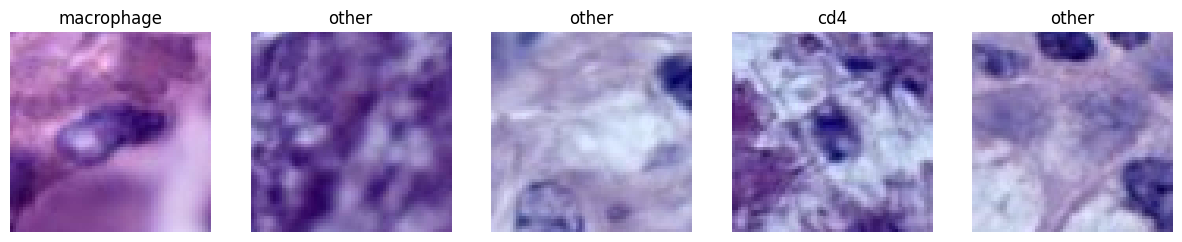

In [11]:
# Sanity check function
def visualize_samples(dataset, num_samples=5, mapping=label_to_index):
    inverted_mapping = {v:k for k,v in label_to_index.items()}
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    indices = torch.randint(0, len(dataset), (num_samples,)).tolist()  # Convert to list of integers
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        label = inverted_mapping[int(label.numpy())]
        image = image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        image = image.numpy()
        
        image_min = np.min(image)
        image_max = np.max(image)
        normalized_image = (image - image_min) / (image_max - image_min)
        
        axes[i].imshow(normalized_image)
        axes[i].set_title(label)
        axes[i].axis("off")
    plt.show()

# Visualize a few samples
visualize_samples(dataset)

#### However, we need to split up this data so we can validate and test the model too...

In [12]:
# Downsample the data since it will take forever to train otherwise
metadata_file = os.path.join(DATA_DIR, "curated_ImmunoctoV1_refinement2.csv")
meta_df = pd.read_csv(metadata_file)

shuffled_df = meta_df.sample(frac=0.0001, random_state=42)
print("len(shuffled_df)", len(shuffled_df))

metadata_file = os.path.join(DATA_DIR, "Immunocto_subset.csv")
shuffled_df.to_csv(metadata_file, index=False)

dataset = ImmunOctoDataset(root_dir=DATA_DIR, csv_file="Immunocto_subset.csv", 
                           transform=transform, label_mapping=label_to_index)

# Split dataset by patient
patients = list(shuffled_df['patient'].unique())  # Ensure it's a list
n_train = int(0.7 * len(patients))
n_val = int(0.2 * len(patients))
n_test = len(patients) - n_train - n_val

train_patients, val_patients, test_patients = patients[:n_train], patients[n_train:n_train+n_val], patients[n_train+n_val:]

train_data = dataset.data[dataset.data['patient'].isin(train_patients)]
val_data = dataset.data[dataset.data['patient'].isin(val_patients)]

metadata_file = "Immunocto_subset.csv"
train_dataset = ImmunOctoDataset(root_dir=dataset.root_dir, csv_file=metadata_file, transform=dataset.transform, label_mapping=label_to_index)
train_dataset.data = train_data
val_dataset = ImmunOctoDataset(root_dir=dataset.root_dir, csv_file=metadata_file, transform=dataset.transform, label_mapping=label_to_index)
val_dataset.data = val_data

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

len(shuffled_df) 685


In [13]:
print(len(train_loader), len(val_loader))

18 4


## 5. Choose the model

In [14]:
# Load and adjust the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modify the first convolutional layer
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Modify the average pooling layer
model.avgpool = nn.AdaptiveAvgPool2d(1)

# Adjust final layer for classification
num_ftrs = model.fc.in_features
num_unique_classes = 5  # (cd4, cd8, bcell, mac, other)
model.fc = nn.Linear(num_ftrs, num_unique_classes)  
model = model.to(device)

## 6. Define the training loop

In [15]:
# Training Code with Model Saving
def train_model(train_loader, val_loader, num_epochs=10, learning_rate=0.0001, save_path="best_model.pth"):
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_scripted = torch.jit.script(model) 
            model_scripted.save(save_path) 
            print(f"Model saved! {save_path}")

        # Save loss values
        if len(train_losses) > 2:
            stats_df = pd.DataFrame({
                'epoch': list(range(1, epoch+2)), 
                'train_loss': train_losses, 
                'val_loss': val_losses
            })
            stats_df.to_csv('output/loss_stats.tsv', sep="\t", index=False)
                                    
            # Plot loss curves                        
            plt.figure()
            plt.plot(range(1, epoch+2), train_losses, label='Train Loss', marker='o')
            plt.plot(range(1, epoch+2), val_losses, label='Validation Loss', marker='s')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training and Validation Loss')
            plt.savefig('output/loss_plot.png')
    
    print("Training complete!")
    return model

## 7. Train the model

Epoch 1/100, Train Loss: 1.5796, Val Loss: 1.4695
Model saved! output/best_model.pt
Epoch 2/100, Train Loss: 1.3107, Val Loss: 1.3313
Model saved! output/best_model.pt
Epoch 3/100, Train Loss: 1.0780, Val Loss: 1.2339
Model saved! output/best_model.pt
Epoch 4/100, Train Loss: 0.8824, Val Loss: 1.1474
Model saved! output/best_model.pt
Epoch 5/100, Train Loss: 0.7192, Val Loss: 1.0580
Model saved! output/best_model.pt


KeyboardInterrupt: 

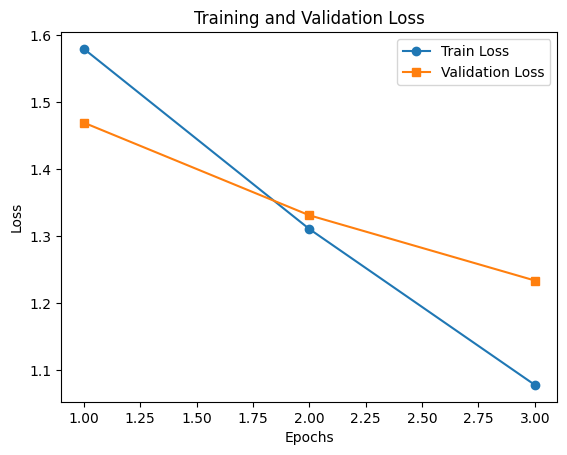

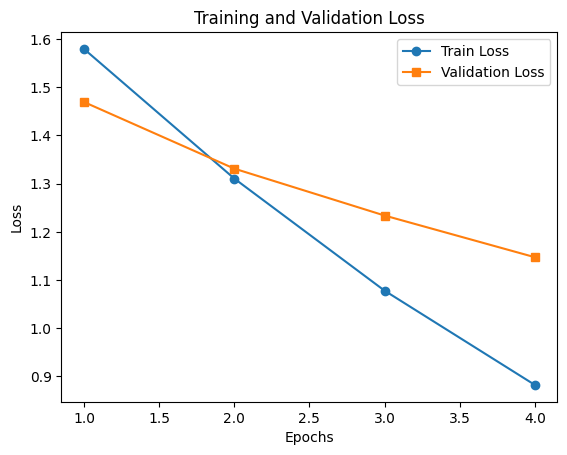

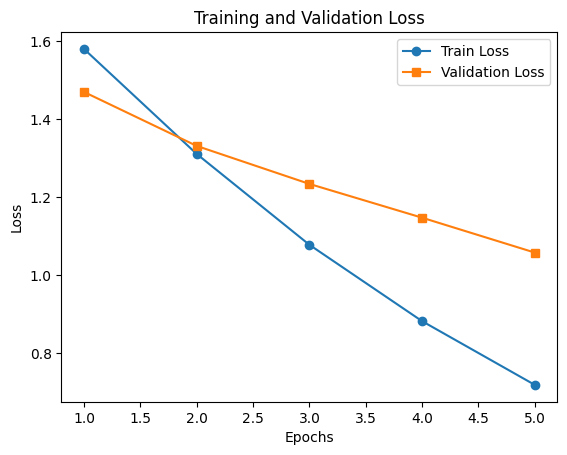

In [16]:
trained_model = train_model(train_loader, val_loader, 
                            num_epochs=100, 
                            learning_rate=0.00001, 
                            save_path="output/best_model.pt")

## 8. Evalulate the trained model performance

In [28]:
# Load test data
test_data = dataset.data[dataset.data['patient'].isin(test_patients)]
test_dataset = ImmunOctoDataset(root_dir=dataset.root_dir, csv_file=metadata_file, transform=dataset.transform, label_mapping=label_to_index)
test_dataset.data = test_data
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [29]:
print(len(test_loader))

2


In [30]:
# Load the model
trained_model = torch.jit.load('output/best_model.pt')
trained_model.eval();

In [31]:
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred_list = torch.argmax(outputs, dim=1).numpy().tolist()
        predicted_labels.extend(pred_list)
        true_labels.extend(labels.numpy().tolist())

In [32]:
eval_df = pd.DataFrame({'predicted_label':predicted_labels,'true_label':true_labels})
accuracy = (eval_df['predicted_label'] == eval_df['true_label']).sum() / len(eval_df)

In [34]:
eval_df

,predicted_label,true_label
0,4,4
1,4,0
2,4,2
3,4,4
4,4,4
5,0,4
6,4,4
7,4,4
8,4,4
9,4,4


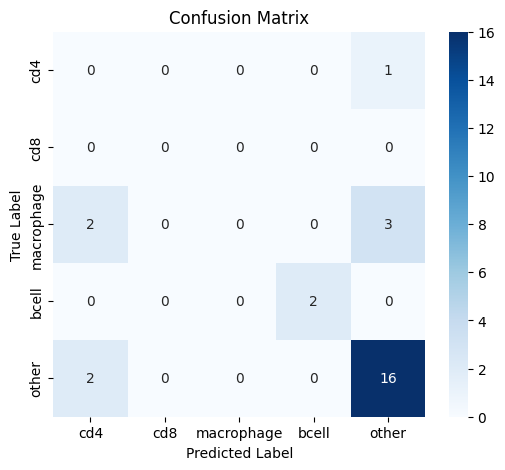

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Cell type mapping
cell_type_dict = {v:k for k,v in label_to_index.items()}
labels = list(cell_type_dict.keys())  # Numeric labels

# Compute confusion matrix
cm = confusion_matrix(eval_df['true_label'], eval_df['predicted_label'], labels=labels)

# Convert numeric indices to cell type names
cell_type_names = [cell_type_dict[label] for label in labels]

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=cell_type_names, 
            yticklabels=cell_type_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save to file and show
plt.savefig("output/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [36]:
print(f"The model's accuracy is: {round(float(accuracy)*100, 1)}%")

The model's accuracy is: 69.2%
